In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
! pip install keras==2.2.4
! pip install tensorflow==1.13.1
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite
# ! pip install allennlp

In [2]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import csv
from gensim.models.keyedvectors import KeyedVectors
from scripts.vocabulary import Vocabulary
from scripts.ner_model import NerModel
from scripts.utils import filter_embeddings
import scripts.utils


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [0]:
data = pd.read_csv("/content/drive/My Drive/NER/train_input.csv", quotechar = '"',sep=',',keep_default_na=False,quoting=csv.QUOTE_NONNUMERIC)


In [0]:
data = data.fillna(method="ffill")


In [5]:
data.tail(10)


Sentence#             Word Tag
1215240  Sentence:85627                ,   0
1215241  Sentence:85627               od   0
1215242  Sentence:85627              lat   0
1215243  Sentence:85627  funkcjonującego   0
1215244  Sentence:85627               na   0
1215245  Sentence:85627        wysokości   0
1215246  Sentence:85627        straganów   0
1215247  Sentence:85627                z   0
1215248  Sentence:85627       pamiątkami   0
1215249  Sentence:85627                .   0

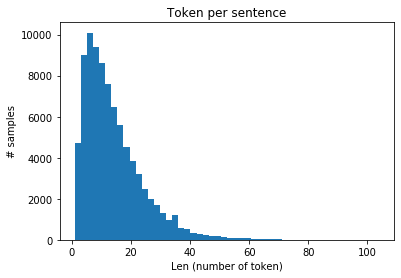

In [6]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Tag_1), ..., (Token_n,  Tag_n)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence#").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [0]:
sentence_x = [[w[0] for w in s] for s in sentences]

In [0]:
sentence_y = [[w[1] for w in s] for s in sentences]

In [0]:
from scripts.index_transformer import IndexTransformer

In [10]:
max_len = 140
max_len_char = 75
transformer = IndexTransformer(lower=True, max_sent_len=max_len, max_word_len=max_len_char)
transformer.fit(sentence_x, sentence_y)
print(transformer.label_size)
print(transformer.word_vocab_size)
print(transformer.char_vocab_size)


39
126741
167


In [11]:
print(transformer._word_vocab.id_to_token(0))
print(transformer._word_vocab.id_to_token(1))
print(transformer._word_vocab.id_to_token(2))

print(transformer._word_vocab.token_to_id('napewnonieznanywyraz'))
print(transformer._word_vocab.token_to_id("<pad>"))
print(transformer._word_vocab.token_to_id('ale'))

print(transformer._label_vocab.token_to_id('<pad>'))

<pad>
<unk>
.
1
0
23
0


In [12]:
print(transformer._word_vocab.token_to_id("Obama"))
print(transformer._label_vocab.token_to_id("B-date"))

86216
10


In [0]:
X,y = transformer.transform(sentence_x, sentence_y)

In [14]:
X_word = X[0]
X_word.shape

(85628, 140)

In [15]:
X_char = X[1]
X_char.shape

(85628, 140, 75)

In [16]:
y.shape

(85628, 140, 39)

In [0]:
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

In [0]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from keras_contrib.layers import CRF


In [0]:

word_vocab_size = transformer.word_vocab_size
n_tags = transformer.label_size
char_vocab_size = transformer.char_vocab_size

In [0]:
char_embedding_dim = 25
word_embedding_dim = 100
char_lstm_size = 25
word_lstm_size = 100

In [21]:
EMBEDDING_PATH = '/content/drive/My Drive/embeddings/nkjp+wiki-forms-all-100-cbow-ns.txt'
all_embeddings = KeyedVectors.load_word2vec_format(EMBEDDING_PATH, unicode_errors='ignore').wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [22]:
EMBEDDING_PATH2 = '/content/drive/My Drive/embeddings/model.txt'
all_embeddings2 = KeyedVectors.load_word2vec_format(EMBEDDING_PATH2, unicode_errors='ignore').wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [23]:
embeddings = filter_embeddings(all_embeddings, transformer._word_vocab.vocab, word_embedding_dim)


17025
109716


In [24]:
embeddings2 = filter_embeddings(all_embeddings2, transformer._word_vocab.vocab, word_embedding_dim)


5629
121112


In [0]:
use_crf = True

In [26]:
embeddings2 is None

False

In [27]:
ner_model = NerModel(char_vocab_size, word_vocab_size, n_tags, use_crf=use_crf, embeddings=embeddings2)
model = ner_model.model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [0]:
model.compile(optimizer="adam", loss=ner_model.loss, metrics=ner_model.metrics)


In [0]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 140, 75)      0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 140)          0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 140, 75, 25)  4175        input_2[0][0]                    
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 140, 100)     12674100    input_1[0][0]                    
__________________________________________________________________________________________________
time_distr

In [31]:
history = model.fit([X_word_tr, X_char_tr],
                    np.array(y_tr).reshape(len(y_tr), max_len, n_tags),
                    batch_size=32, epochs=3, validation_split=0.1, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 69358 samples, validate on 7707 samples
Epoch 1/3
69358/69358 [==============================] - 3171s 46ms/step - loss: 55.0295 - crf_viterbi_accuracy: 0.9631 - val_loss: 55.3661 - val_crf_viterbi_accuracy: 0.9788
Epoch 2/3
69358/69358 [==============================] - 3188s 46ms/step - loss: 54.9437 - crf_viterbi_accuracy: 0.9805 - val_loss: 55.3516 - val_crf_viterbi_accuracy: 0.9821
Epoch 3/3
69358/69358 [==============================] - 3159s 46ms/step - loss: 54.9267 - crf_viterbi_accuracy: 0.9856 - val_loss: 55.3448 - val_crf_viterbi_accuracy: 0.9850


In [32]:
from random import randint
from keras_contrib.utils import save_load_utils

run_id = randint(0, 10000)
transformer.save(f'index_transformer_{run_id}.pkl')
if use_crf:
  filename = f'/content/drive/My Drive/NER/crf_model_{run_id}.h5'
  save_load_utils.save_all_weights(model, filename)
else:
  filename = f'/content/drive/My Drive/NER/model_{run_id}.h5'
  model.save(filename)
print('Saving model to file' + filename)


Saving model to file/content/drive/My Drive/NER/crf_model_9143.h5


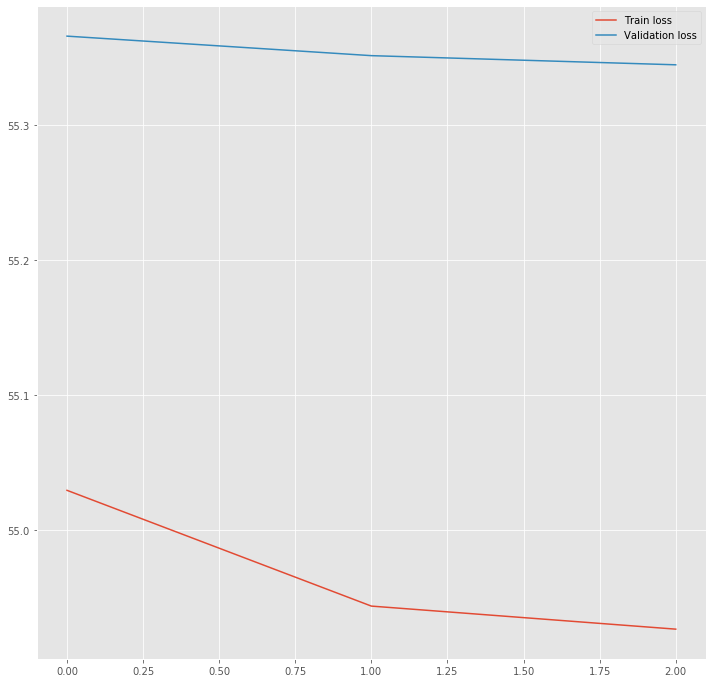

In [33]:
hist = pd.DataFrame(history.history)
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist['loss'], label='Train loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()
plt.show()

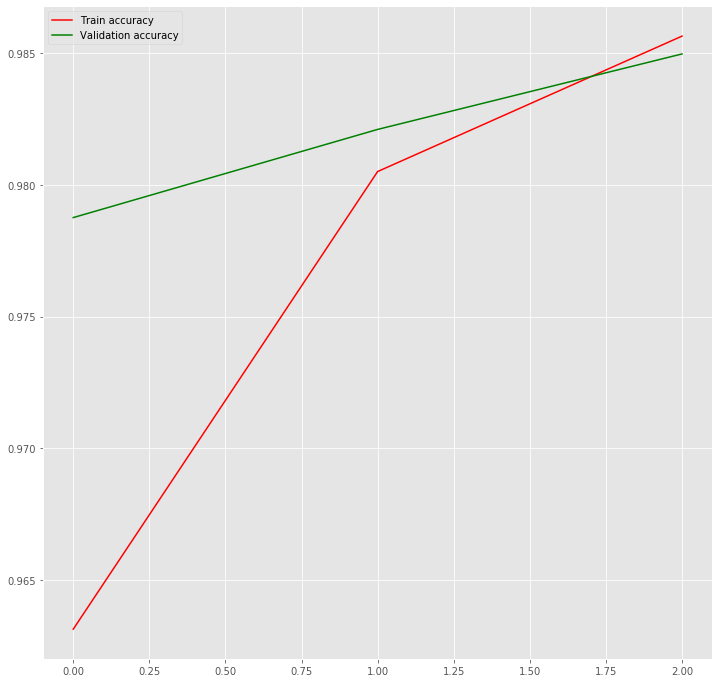

In [34]:
hist = pd.DataFrame(history.history)
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist['crf_viterbi_accuracy'], 'r', label='Train accuracy')
plt.plot(hist['val_crf_viterbi_accuracy'], 'g', label='Validation accuracy')
plt.legend()
plt.show()

In [0]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])

In [36]:
yy_p = transformer.inverse_transform(y_pred)
len(yy_p)

8563

In [37]:
yy_te = transformer.inverse_transform(y_te)
len(yy_te)

8563

In [38]:
from sklearn_crfsuite.metrics import flat_classification_report
report = flat_classification_report(y_pred=yy_p, y_true=yy_te)
print(report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                           precision    recall  f1-score   support

                                        0       0.99      1.00      1.00    114499
                                    <pad>       1.00      1.00      1.00   1075433
                                   B-date       0.95      0.91      0.93       446
                            B-date#I-date       0.00      0.00      0.00        15
                               B-geogName       0.77      0.70      0.73       417
                                B-orgName       0.85      0.77      0.81      1114
            B-orgName#B-placeName_country       0.75      1.00      0.86         9
         B-orgName#B-placeName_settlement       0.90      0.41      0.56        22
                               B-persName       0.85      0.64      0.73       111
            B-persName#B-persName_addName       0.59      0.15      0.24        87
           B-persName#B-persName_forename       0.95      0.91      0.93      1331
   

In [39]:
i = 55
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], yy_te[i], yy_p[i]):
    if w != 0:
        print("{:15}: {:25} {:25}".format(transformer._word_vocab.id_to_token(w), t, pred))



Word           ||True ||Pred
-              : 0                         0                        
trzeba         : 0                         0                        
się            : 0                         0                        
czasami        : 0                         0                        
pokłócić       : 0                         0                        
,              : 0                         0                        
bo             : 0                         0                        
życie          : 0                         0                        
było           : 0                         0                        
by             : 0                         0                        
nudne          : 0                         0                        
–              : 0                         0                        
mówi           : 0                         0                        
pani           : 0                         0                        
jadwi